### Importation des bibliothèques


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import ComplementNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import joblib

### Importation et prétraitement des données

In [ ]:
#Import the Dataset
df= pd.read_csv("/kaggle/input/phishingemails/Phishing_Email.csv")
# Assuming df is your DataFrame
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

In [45]:
# Vérifier les valeurs NAN
df.isna().sum()

Email Text    16
Email Type     0
dtype: int64

In [46]:
#Supprimer les valeurs Na
df = df.dropna()
print(df.isna().sum())

Email Text    0
Email Type    0
dtype: int64


In [47]:
#forme du jeu de données
df.shape

(18634, 2)

In [48]:
# Compter les occurrences de chaque type d'E-mail. 
email_type_counts = df['Email Type'].value_counts()
print(email_type_counts)


Email Type
Safe Email        11322
Phishing Email     7312
Name: count, dtype: int64


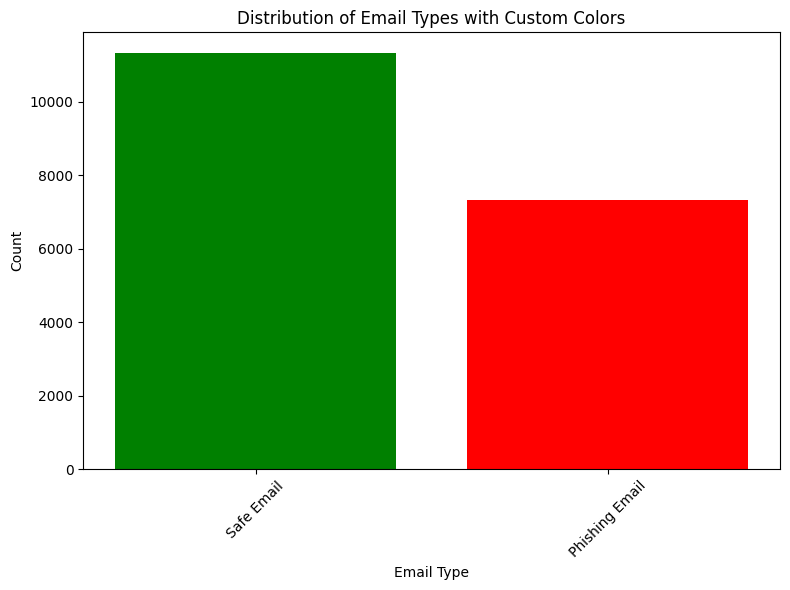

In [49]:

unique_email_types = email_type_counts.index.tolist()

color_map = {
    'Phishing Email': 'red',
    'Safe Email': 'green',}


colors = [color_map.get(email_type, 'gray') for email_type in unique_email_types]


plt.figure(figsize=(8, 6))
plt.bar(unique_email_types, email_type_counts, color=colors)
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.title('Distribution of Email Types with Custom Colors')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()


### Stratégies pour gérer le déséquilibre

Pour aborder le problème de déséquilibre des classes, nous envisagerons les stratégies suivantes :

#### 1. Techniques de rééchantillonnage

   a.**Suréchantillonnage :** Nous augmenterons le nombre d'instances dans la ou les classes minoritaires en générant des échantillons synthétiques (par exemple, en utilisant SMOTE) pour équilibrer la distribution des classes.

   b. **Sous-échantillonnage :** Nous pouvons réduire le nombre d'instances dans la classe majoritaire pour correspondre à la classe minoritaire, équilibrant ainsi efficacement le jeu de données.

In [50]:
 Safe_Email = df[df["Email Type"]== "Safe Email"]
Phishing_Email = df[df["Email Type"]== "Phishing Email"]
Safe_Email = Safe_Email.sample(Phishing_Email.shape[0])

In [51]:
Safe_Email.shape,Phishing_Email.shape

((7312, 2), (7312, 2))

In [52]:
Data= pd.concat([Safe_Email, Phishing_Email], ignore_index = True)
Data.head()

,Email Text,Email Type
0,URL: http://jeremy.zawodny.com/blog/archives/0...,Safe Email
1,"re : october wellhead julie , the camden and n...",Safe Email
2,> I wonder if the focus of spambayes ought not...,Safe Email
3,bitbitch@magnesium.net writes:> SL> \n> SL> Mi...,Safe Email
4,\nJH> They are legally required to do that. I...,Safe Email


### Notre jeu de données est prêt

In [53]:
X = Data["Email Text"].values
y = Data["Email Type"].values

In [54]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Modèle avec optimisation

In [ ]:
text_data = Data["Email Text"]
text_data = text_data.dropna()
# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the text data from the DataFrame
vectorizer.fit(text_data)

In [57]:
joblib.dump(vectorizer, "vectorizer.joblib")

['vectorizer.joblib']

In [ ]:
models = [
    (Pipeline([("tfidf", vectorizer), ("classifier", RandomForestClassifier())]), {'classifier__n_estimators': [10]}),
    # (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", DecisionTreeClassifier())]), {'classifier__max_depth': [None, 10]}),
    # (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", AdaBoostClassifier())]), {'classifier__n_estimators': [50], 'classifier__learning_rate': [1.0]}),
    # (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", SGDClassifier())]), {'classifier__max_iter': [1000], 'classifier__tol': [1e-3]}),
    # (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", LogisticRegression())]), {'classifier__C': [1.0], 'classifier__max_iter': [100]}),
    # (Pipeline([("tfidf", vectorizer),("classifier", MultinomialNB())])),
    # (Pipeline([("tfidf", vectorizer),("classifier", BernoulliNB())])),
    # (Pipeline([("tfidf", vectorizer),("classifier", ComplementNB())]))
]

accuracy_test = []
model_names = []

for pipeline, params in models:
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'###### Model => {model_name}')
    
    grid_search = GridSearchCV(pipeline, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    accuracy_test.append(acc)
    model_names.append(model_name)
    joblib.dump(best_model, f"{model_name}.joblib")
    
    print(f'Test Accuracy : {acc*100:.5f}%')
    print('Classification Report')
    print(classification_report(y_test, pred))
    print('Confusion Matrix')
    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    print('################### End ###################')

# Rapport final pour le modèle avec optimisation

In [67]:
model_series = pd.Series(model_names, name='Model').astype(str)  
accuracy_series = pd.Series(accuracy_test, name='Accuracy')  
output = pd.concat([model_series, accuracy_series], axis=1)

In [68]:
output

,Model,Accuracy
0,RandomForestClassifier,0.936190
1,DecisionTreeClassifier,0.891978
2,AdaBoostClassifier,0.924567
3,SGDClassifier,0.980857
4,LogisticRegression,0.971969


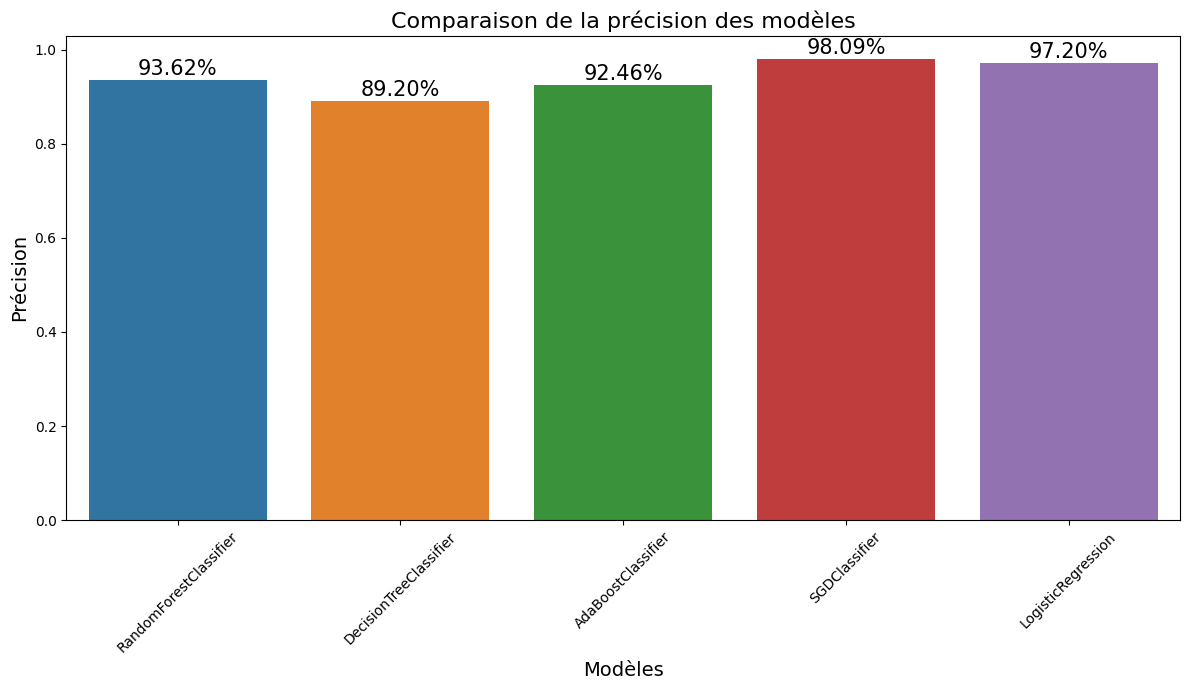

In [69]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2%'), 
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Modèles", fontsize=14)
plt.ylabel("Précision", fontsize=14)
plt.title("Comparaison de la précision des modèles", fontsize=16)  
plt.xticks(rotation=45)  
plt.tight_layout()  

plt.show()

## Conclusion

Dans notre exploration approfondie visant à améliorer la détection des e-mails de phishing, nous avons entrepris un voyage à travers les domaines de l'apprentissage automatique, appliquant une approche structurée pour déterminer le modèle le plus efficace pour distinguer entre les e-mails de phishing et les e-mails légitimes. Notre enquête s'est centrée sur un éventail de cinq modèles d'apprentissage automatique distincts : RandomForestClassifier, DecisionTreeClassifier, AdaBoostClassifier, SGDClassifier et LogisticRegression. Cette entreprise a été marquée par un processus d'évaluation méticuleux, employant à la fois l'ajustement des hyperparamètres via GridSearchCV et une évaluation simple avec les paramètres par défaut des modèles.

### Évaluation du modèle et aperçus

L'évaluation s'est déroulée en deux phases. Initialement, nous nous sommes engagés dans **l'ajustement des hyperparamètres avec l'aide de GridSearchCV pour tous les modèles**, visant à identifier les réglages optimaux qui maximiseraient leur précision de classification. Parmi les modèles examinés, le **SGDClassifier** s'est démarqué, livrant une précision impressionnante de **`97%` **. Cette phase a souligné le rôle crucial de l'optimisation des hyperparamètres dans l'affinement de la performance du modèle, permettant au **SGDClassifier** d'identifier adroitement les tentatives de phishing avec une précision remarquable.

En passant à la deuxième phase, nous avons revisité la même série de modèles, **cette fois en s'abstenant de tout ajustement des hyperparamètres**. Cette approche était fondée sur l'hypothèse que les modèles pourraient toujours bien performer avec leurs configurations par défaut. Les résultats ont été éclairants, avec le **SGDClassifier prenant à nouveau la tête**, bien que cette fois en atteignant une précision encore plus élevée de **`98%`**. Ce résultat inattendu a mis en lumière l'efficacité intrinsèque des paramètres par défaut du SGDClassifier, qui se sont avérés exceptionnellement aptes à classer les e-mails avec précision, surpassant même les résultats obtenus à partir du processus minutieux d'ajustement des hyperparamètres.

### Conclusion et recommandations

Les résultats de notre enquête offrent des preuves convaincantes de la puissance du SGDClassifier dans le domaine de la détection des e-mails de phishing. Il est évident que, bien que l'ajustement des hyperparamètres soit un outil précieux pour améliorer la précision du modèle, les paramètres par défaut de certains modèles, tels que le SGDClassifier, sont suffisamment robustes pour des tâches spécifiques comme la classification des e-mails de phishing. Cette réalisation est particulièrement bénéfique pour les applications où les ressources informatiques ou les contraintes de temps sont une considération, permettant le déploiement d'une solution efficace et efficiente sans la nécessité d'un réglage extensif.
